# Report Geoextent

Ideas for 'abstract'

Academic repositories store all kind of files that allow reasearchers to share information about their investigations. Some of those files include the analyzed datasets or the code used for their analysis. In this regard, the files available in each repositority include not only information of individual measurements or methods, but relevant characteristics of the studies as its **temporal** or **spatial extent**. Despite the fact that these characteristics are present in almost all studies (e.g. data is collected in an area during a period of time) searching repositories by these component is limited to keyworkds (e.g. name of countries) or limited tools (**TODO: add source**). For example, in Zenodo (academic repository) __[spatial searchs](https://zenodo.org/api/records/?bounds=-180,-90,180,90)__ are limited to the inclusion of
__[locations](https://developers.zenodo.org/#depositions)__ parameter in the metadata of the repository.


These limitations dificults researchers finding datasets and publications for specific areas or periods of time.

In this sense, the goal of this report is to extract the **spatial** and/or **temporal extent** of available academic repositories by inspecting their content (files) by using the __geoextent__ package. While exploring academic repositories our objective is to understand what are the most common formats to share geographic (spatial) or temporal information used by researchers, and determine in what extent the current version of __geoextent__ is capable to extract these parameters. 


# Introduction

## Database extraction

These sets of functions download databases by using their DOI from four academic repositories. The functions also extracts the metadata of the database (e.g., location if available).

### DOI to repository identification

In [220]:
#TODO
# This functions use as an input the DOI of a dataset and returns the name of the academic repository where it
# is hosted (Zenodo,Figshare,GFZ Data Services, Pangaea) and their ID in the corresponding repository.

#### Zenodo
##### Getting list of records
The following method extracts all the zenodo ids from an specific search term.

In [221]:
import requests
import json

def get_list_of_records(term,mb_size = False,bounds = False):
    
    parameters = {'q':str(term),
              "access_right":"open",
              "size" : "1",
              "type":"dataset"}
    
    if bounds is not False:
    
        try:
            min_lon,min_lat,max_lon,max_lat = bounds[0],bounds[1],bounds[2],bounds[3]
            
            if min_lon < max_lon and min_lat < max_lat:
                
                if min_lon in range(-180,181) and min_lat in range(-90,91) and max_lon in range (-180,181) and max_lat in range (-90,91):
                    bbox = str(bounds[0])+","+str(bounds[1])+","+str(bounds[2])+","+str(bounds[3])
                    parameters['bounds'] = bbox
                else:
                    print("Invalid bounds. Bounds parameter is going to be ignore. >limite")   
            else:
                print("Invalid bounds. Bounds parameter is going to be ignore.")
        except:
            print("Invalid bounds. Bounds parameter is going to be ignore. Error")
    
    if term is False:
        parameters.pop("q")
    
    response_hits = requests.get('https://zenodo.org/api/records/',
                              params=parameters)
    
    
    hits = response_hits.json()['hits']['total']
    
    print("{} repositories found for your query.".format(hits))
    zenodo_search = {}
    
    if hits > 0 :
        
        parameters["size"]=str(hits)
        
        response = requests.get('https://zenodo.org/api/records/',
                              params=parameters)
        
        content = response.json()

    for i in range(0,hits):
        
        files = content['hits']['hits'][i]['files']
        size = round(sum(f['size'] for f in files)/2 **20,1)
        
        if size <= mb_size or mb_size is False:
            record_id = content['hits']['hits'][i]['conceptrecid']
            doi = content['hits']['hits'][i]['doi']
            title = content['hits']['hits'][i]['metadata']['title']
            license = content['hits']['hits'][i]['metadata']['license']['id']
            zenodo_search[record_id] = {"doi":doi,"title":title,"license":license,"size_mb":size}
    
    if mb_size is not False:
        print("{} out of {} repositories smaller than {} MB".format(len(zenodo_search),hits,mb_size))

    return zenodo_search

#### Figshare


In [222]:
#TODO

# This function downloads a Figshare repository and extracts the available metadata

#### GFZ Data Services

In [223]:
#TODO

# This function downloads a GFZ Data Services repository and extracts the available metadata

#### Pangaea

In [224]:
#TODO

# This function downloads a Pangaea repository and extracts the available metadata

### Geographic extent

These sets of functions iterate through the repositories and extract the geospatial information.

1. If an extent is found (or if not = NA), Add record URL, ID, and some record metadata (names of contained files, author, repository URL, license, ...),  and the resulting extent in WKT in a local "database" in GeoPackage format.

2. If not extent is found, store the record as visited and the list of filenames

In [225]:
import geoextent.lib.extent as geoextent
import zenodo_get as zget
import tempfile
import os
import sys
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from pyproj import CRS
import itertools
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

#### Geographic extent repositories

This method extracts the repository information from the geoextent 'details' function output. The output is a dataframe with relevant features of each repository.

In [226]:
def rep_to_table(list_records):
    """ Extracts repository info from list_records
    Keyword arguments:
    list_records -- dictionary with geoextent extraction by repository 
    """
    
    repository_id = []
    title = []
    doi = []
    license = []
    tbox = []
    bbox = []
    crs = []
    
    for i in list_records:

        repository_info = list_records[i]
        repository_id.append(i)
        title.append(repository_info.get('title'))
        doi.append(repository_info.get('doi'))
        license.append(repository_info.get('license'))
        geoextent = repository_info.get('geoextent')
        
        if geoextent is not None:
            tbox.append(geoextent.get('tbox'))
            bbox.append(geoextent.get('bbox'))
            crs.append(geoextent.get('crs'))
        else:
            tbox.append(None)
            bbox.append(None)
            crs.append(None)
            
    def transform_bbox(x):
        try:
            bbox = shapely.geometry.box(*x)
        except:
            bbox = None    
        return bbox
    
    bbox = list(map(lambda x: transform_bbox(x) if x is not None else None,bbox))
    tbox = list(map(lambda x: str(x[0])+'/'+str(x[1]) if x is not None else None, tbox))
    d = {'repository_id': repository_id, 'title': title, 'doi':doi,'license':license,
        'bbox':bbox,'tbox':tbox,'crs':crs}
    
    repositories = pd.DataFrame(d)
  
    return repositories

#### Geographic extract details

This method extracts the file details from the geoextent 'details' function output for a **single folder**.

In [227]:
def extract_details(details,repository=1):
    """ Extracts details from geoextent extraction
    Keyword arguments:
    details -- dictionary with geoextent extraction by repository
    repository -- Parent repository
    """

    filename = []
    file_format = []
    handler = []
    bbox = []
    tbox = []
    crs = []
    
    for i in details:
        
        file = details[i]
        
        if file is None:
            filename.append([i])
            file_format_v = os.path.splitext(i)[1][1:]
            if file_format_v is '':
                file_format_v = 'undetected'
            file_format.append([file_format_v])
            handler.append([None])
            bbox.append([None])
            tbox.append([None])
            crs.append([None])
        else:
            filename.append([i])
            file_format.append([file.get('format')])    
            handler_v = file.get('geoextent_handler')
            bbox_v = file.get('bbox')
            tbox_v = file.get('tbox')
            crs_v = file.get('crs')
            handler.append([handler_v])
            bbox.append([bbox_v])
            tbox.append([tbox_v])
            crs.append([crs_v])
            
            if file.get('format')=='folder':
                
                details_folder = extract_details(file['details'],repository)
                filename.append(details_folder['filename'])
                file_format.append(details_folder['format'])
                handler.append(details_folder['handler'])
                bbox.append(details_folder['bbox'])
                tbox.append(details_folder['tbox'])
                crs.append(details_folder['crs'])
    
    if any(isinstance(i, list) for i in filename):
        filename = list(itertools.chain.from_iterable(filename))
        file_format=  list(itertools.chain.from_iterable(file_format))
        handler = list(itertools.chain.from_iterable(handler))
        bbox= list(itertools.chain.from_iterable(bbox))
        tbox = list(itertools.chain.from_iterable(tbox))
        crs = list(itertools.chain.from_iterable(crs))
        
    repository_id = [repository]*len(filename) 
    d = {'repository':repository_id,'filename': filename, 'format': file_format, 'handler':handler,'bbox':bbox,'tbox':tbox,'crs':crs}
    return d

#### Geographic extract file details

This method extracts the file details from the geoextent 'details' function output for **multiple folders** by using the _extract_details()_ function. The output is a dataframe with relevant features of each file.

In [228]:
def files_to_table(list_records):
    
    """ Extracts file information from list_records
    Keyword arguments:
    list_records -- dictionary with geoextent extraction by repository 
    """
    
    filename = []
    rep_id = []
    file_format = []
    handler = []
    tbox = []
    bbox = []
    crs = []

    for rep in list_records:

        geoextent = list_records[rep]['geoextent']
        
        if geoextent is not None:
            details = geoextent.get('details')
            repository = extract_details(details,rep)
            rep_id.append(repository.get('repository'))
            filename.append(repository.get('filename'))
            file_format.append(repository.get('format'))
            handler.append(repository.get('handler'))
            tbox.append(repository.get('tbox'))
            bbox.append(repository.get('bbox'))
            crs.append(repository.get('crs'))
        else:
            filename.append([None])
            rep_id.append([rep])
            file_format.append([None])
            handler.append([None])
            tbox.append([None])
            bbox.append([None])
            crs.append([None])
            
    if any(isinstance(i, list) for i in filename):
        rep_id = list(itertools.chain.from_iterable(rep_id))
        filename = list(itertools.chain.from_iterable(filename))
        file_format =  list(itertools.chain.from_iterable(file_format))
        handler = list(itertools.chain.from_iterable(handler))
        bbox= list(itertools.chain.from_iterable(bbox))
        tbox = list(itertools.chain.from_iterable(tbox))
        crs = list(itertools.chain.from_iterable(crs))
        
    def transform_bbox(x):
        try:
            bbox = shapely.geometry.box(*x)
        except:
            bbox = None    
        return bbox
    
    bbox = list(map(lambda x: transform_bbox(x) if x is not None else None,bbox))
    tbox = list(map(lambda x: str(x[0])+'/'+str(x[1]) if x is not None else None, tbox))
    
    d = {'repository':rep_id,'filename': filename, 'format': file_format, 'handler':handler,'bbox':bbox,'tbox':tbox,'crs':crs}
    files = pd.DataFrame(d)
    
    return files

##### Download repository from zenodo and inspect geoextent

This function downloads a repository by their **zenodo_id**, and then extract the geographical extent and temporal extent by using _geoextent_

In [229]:
from IPython.utils import io

def zenodo_geoextent(zenodo_id):
    """Download a zenodo repository and extract the geoextent
    Keyword arguments:
    zenodo_id -- zenodo id of repository.
    """
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_dir_dest = os.path.join(tmp_dir,str(zenodo_id))
        with io.capture_output() as captured:
            zget.zenodo_get([str(zenodo_id),"-e","-o",tmp_dir_dest])
        geo_extent = geoextent.fromDirectory(tmp_dir_dest, True, True, True)
        
    return geo_extent

### Geoextent 

In [230]:
#Get list of records

def geoextent_by_search_term_zenodo(term="geo",mb_size = False,bounds = False,output_path="geo_all.gpkg"):
    """ Extract geoextent of zenodo repositories base on a search term
    Keyword arguments:
    term -- search term (default "geo")
    mb_size -- mb size limit (double) defaul (False) if False there is no size limit
    output_path --  file name to return summary tables from extraction in a geopackage file
    """
    
    list_records = get_list_of_records(term,mb_size,bounds)
    num_repositories = len(list_records)
    error_ids = []
    counter = 1
    for i in list_records:
        print(str(counter)+" out of "+ str(num_repositories)+" repositories analyzed", end='\r')
        counter += 1
        try:
            list_records[i]['geoextent'] = zenodo_geoextent(i)
        except:
            list_records[i]['geoextent'] = None
            error_ids.append(i)
    
    try:
        repo = rep_to_table(list_records)     
        files = files_to_table(list_records)
        gdf_repo = gpd.GeoDataFrame(repo, geometry='bbox', crs=CRS("EPSG:4326"))
        gdf_files = gpd.GeoDataFrame(files, geometry='bbox', crs=CRS("EPSG:4326"))
        gdf_files.to_file(output_path, layer="files", driver="GPKG")
        gdf_repo.to_file(output_path, layer="repositories", driver="GPKG")

    except:
        print("Error exporting results into GeoPackage.")
        return list_records
    
    data = {"list_record":list_records,"error_ids":error_ids}
    
    return data

### Use example:

In [231]:
import warnings
import logging
warnings.simplefilter("ignore")
logging.disable(sys.maxsize)

f = geoextent_by_search_term_zenodo(term="geo",mb_size = 0.1,bounds=False, output_path="geo_p1_mb.gpkg");
logging.disable(logging.NOTSET)

222 repositories found for your query.
25 out of 222 repositories smaller than 0.1 MB
There is no time value for GeoTIFF files


# Results

After the extraction of geographical and temporal extent of zenodo repositories, the geopackage file is loaded to inspect the results. The geopackage contains two tables, the first one **repositories** and the second one **files**. The two tables are tied together by using the **repository_id** (repositories) and **repository** (for files) property.

In [232]:
repositories_gdf = gpd.read_file("geo_200.gpkg",layer="repositories")
files_gdf = gpd.read_file("geo_200.gpkg",layer="files")

num_repositories = len(repositories_gdf)
num_files = len(files_gdf)

# File type 'folder' is removed to avoid repetition of information
index = files_gdf[files_gdf['format'] == 'folder'].index
files_gdf.drop(index, inplace=True)

# File 'md5sums.txt' file is removed as this file is included by zenodo in all of the repositories
index = files_gdf[files_gdf['filename'] == 'md5sums.txt'].index
files_gdf.drop(index, inplace=True)


##### Results by repository

Portion of repositories table.

In [233]:
repositories_gdf[0:10]

repository_id,title,doi,license,tbox,crs,geometry


##### Results by files

Portion of files table.

In [234]:
from itables import show

files_gdf[20:30]

# As this table could contain thousends of entries, the fview is reduced. Is you want to display all the content, uncomment the following line:
# show(files_gdf, maxBytes=0)
# for more info : # https://mwouts.github.io/itables/#downsampling

,repository,filename,format,handler,tbox,crs,geometry


##### Bounding box 

Visualization of bounding boxes

In [235]:
import folium
from folium import plugins
from folium import  FeatureGroup, LayerControl
from folium.features import GeoJsonPopup 

# Extract only repositories and files with geometry

rep_valid = repositories_gdf[repositories_gdf.geometry.is_valid].copy().reset_index(drop=True)
files_valid = files_gdf[files_gdf.geometry.is_valid].copy().reset_index(drop=True)

m = folium.Map(max_bounds= True,height=500)
stripes = plugins.pattern.StripePattern(angle=-45,color="#f70707")
style = {'fillColor': '#f70707', 'color': '#f70707', 'dashArray': 5,'fillPattern' :stripes,'fillOpacity' : 0.6}   

for i in range(len(rep_valid)):
    fg = FeatureGroup(name=rep_valid["repository_id"][i]).add_to(m)
    folium.GeoJson(data = rep_valid["geometry"][i],
                   name = rep_valid["repository_id"][i],
                   style_function = lambda x: style,
                  ).add_child(
        folium.Popup(
            "<b> REPOSITORY </b>"+
            "<br><b> Repository ID: </b> " + rep_valid["repository_id"][i]+
            "<br><b> Title: </b> " + rep_valid["title"][i] + 
            "<br><b>   D.O.I: </b> </b>" + rep_valid["doi"][i]+
            "<br><b>  License: </b>" + rep_valid["license"][i]+
            "<br><b> tbox: </b>" + str(rep_valid["tbox"][i])
            ,max_width='250')).add_to(fg)
    
    for j in range(len(files_valid)):
        
        if files_valid["repository"][j]==rep_valid["repository_id"][i]:
            folium.GeoJson(data = files_valid["geometry"][j],
                        name = files_valid["repository"][j]).add_child(
                folium.Popup(
                    "<b> FILE </b>"+
                "<br><b> Repository ID of origin: </b> " + files_valid["repository"][j]+
                "<br><b> Filename: </b> " + files_valid["filename"][j]+  
                "<br><b> Format: </b> " + files_valid["format"][j] +
               "<br><b> Geoextent Handler: </b> " + str(files_valid["handler"][j]) 
                ,max_width='400')).add_to(fg)
    
LayerControl().add_to(m)
m

**GRAPH 1: Proportion of repositories with geospatial metadata**

In [236]:
# NUMBER OF REPOSITORIES WITH GEOSPATIAL METADATA / NUMBER OF REPOSITORIES
# what do they answer? 
# Proportion of repositories with geospatial metadata

**GRAPH 2: Proportion of repositories with successful geospatial extraction (Geoextent)**

In [237]:
# NUMBER OF REPOSITORIES WITH SUCCESSFULL GEOSPATIAL EXTRACTION / NUMBER OF REPOSITORIES
# what do they answer? 
# Does geoextent allow to extract geospatial information from repositories in a higher proportion that current metadata ?

**GRAPH 3: Distribution of files in repositories**

Distribution of files found in inspected repositories.

<AxesSubplot:title={'center':'File format distribution in repositories'}>

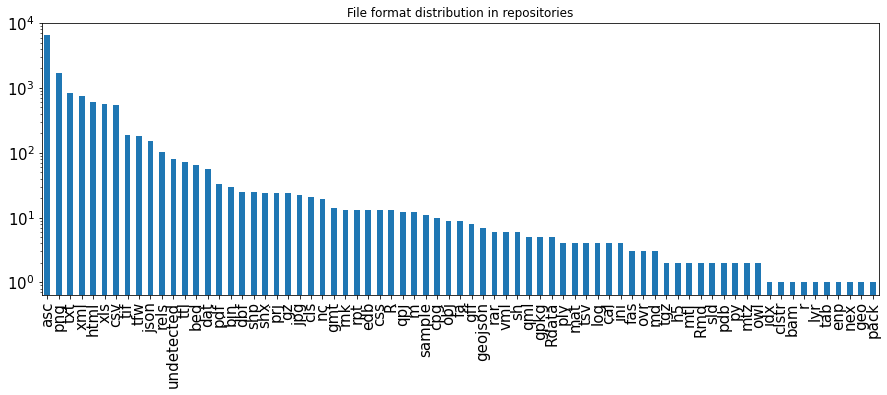

In [238]:
files_gdf['format'].value_counts().plot(kind='bar',
                                        title="File format distribution in repositories",
                                        figsize=(15,5),
                                        logy=True,
                                        fontsize=15)

**GRAPH 4: Occurrence of fileformat in repositories**

Distribution of fileformats in repositories. Percentage of ocurrence of a fileformat in inspected repositories.

<AxesSubplot:title={'center':'File format distribution in repositories'}, xlabel='Fileformat', ylabel='Percentage of ocurrence'>

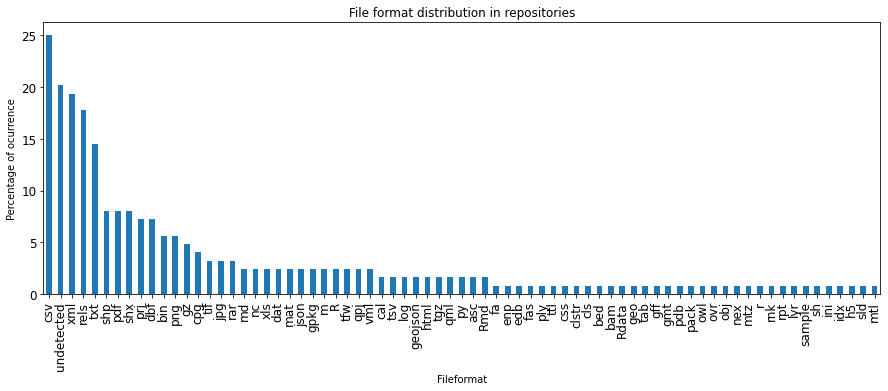

In [239]:
count = files_gdf.groupby(by=['format','repository']).count().groupby(by="format").count()['filename'].sort_values(ascending=False)/num_repositories*100
count.plot(kind='bar',
           title="File format distribution in repositories",
           xlabel = "Fileformat",
           ylabel = "Percentage of ocurrence",
           figsize=(15,5),
           fontsize=12)

**GRAPH 5: Distribution of files in repositories with successful geospatial extraction (Geoextent)**

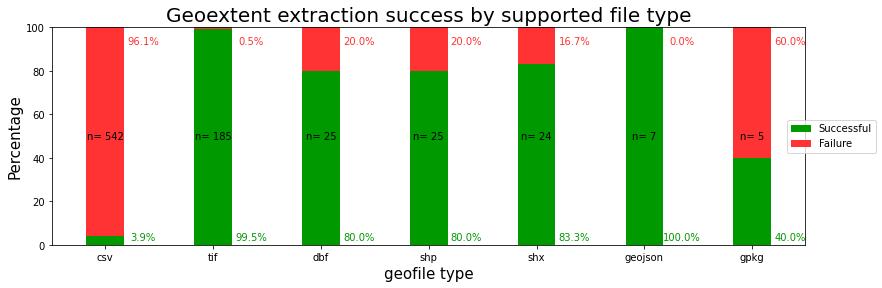

In [240]:
d1 = pd.DataFrame({"Total":files_gdf['format'].value_counts()})
d2 = pd.DataFrame({"geoextent_success":files_valid['format'].value_counts()})

dj = d1.join(d2)
l = dj.dropna().copy()

l['perc_success'] = (l['geoextent_success']/l['Total'])*100

labels = l.index.values
success = l['perc_success']
failure = 100 - l['perc_success']

color_success = "#009900"
color_failure = "#FF3333"

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,4))
width = 0.35
ax.bar(labels, success, width, label='Successful',color= color_success)
ax.bar(labels, failure, width, bottom=success, color = color_failure,label='Failure')
ax.set_ylabel('Percentage',size=15)
ax.set_xlabel('geofile type',size=15)
ax.set_title('Geoextent extraction success by supported file type',size = 20)
ax.set_ylabel('Percentage')

count = 0
for bar in ax.patches: 

    displace =-1
    color = color_failure

    pos = 90
    
    if bar.get_y() == 0:
        
        n = l['Total'][count]
        count+=1
        displace = 3
        color= color_success
        pos = 0
        ax.annotate("n= "+str(n),  
                   (bar.get_x() + (bar.get_width()/2),  
                   50), ha='center', va='center', 
                   size=10, xytext=(0, 0),color='black', 
                   textcoords='offset points')
    
    ax.annotate(format(bar.get_height()/100, ".1%"),  
                   (bar.get_x() + (bar.get_width()*1.5),  
                   pos), ha='center', va='center', 
                   size=10, xytext=(0, 8),color=color, 
                   textcoords='offset points')
    
box = ax.get_position() 
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

In [241]:
geofiles = l.index.values
files_no_geoextent = files_gdf[~files_gdf.geometry.is_valid].copy().reset_index(drop=True)
geofiles_no_geoextent = files_no_geoextent[files_no_geoextent['format'].isin(geofiles)]
geofiles_no_geoextent = geofiles_no_geoextent.merge(repositories_gdf.loc[:,['repository_id','doi']], left_on='repository', right_on='repository_id')

**TABLE 1: Filenames of failed geoextractions**

This table corresponds to the a portion of the files on **graph 6** with no geographical extent detectec by _geoextent_ (i.e "failure"). These files correspond to format files that could be potentially extracted (e.g Shapefiles or Tiff). This table does no include other types of geofiles not present in **graph 6**. 

In [242]:
geofiles_no_geoextent.loc[0:10,["repository","filename","doi"]]

,repository,filename,doi


**GRAPH 6: Distribution of (geo)files in repositories with unsuccessful geospatial extraction (Geoextent)**

In [243]:
# DISTRIBUTION OF FILES IN UNSUCCESSFUL GEOSPATIAL EXTRACTIONS
# what do they answer?
# What type of files (geo but not supported by geoextent) are more popular in the repositories?

#TODO:
#list of files with geoextent (potential source osgeo)
#geofiles = ['cal','csv','dbf','geojson','gff','gmt','gpkg','jpg','json','lyr','pdf','png','prj','shp','shx','tif','tfw','xml']